# Data Analysis

In [1]:
import os
import json
from sqlalchemy import create_engine
import pandas as pd
from plotnine import *
import plotly.express as px
from wordcloud import WordCloud
from IPython.display import display, Image
import custom_functions as cf

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
engine = create_engine('sqlite:///../data/rainy.db', echo=False, isolation_level="AUTOCOMMIT")

with engine.connect() as conn:
    pass

## Perception of London as a rainy city over time

/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: ../docs/images/london_rain_perception.svg


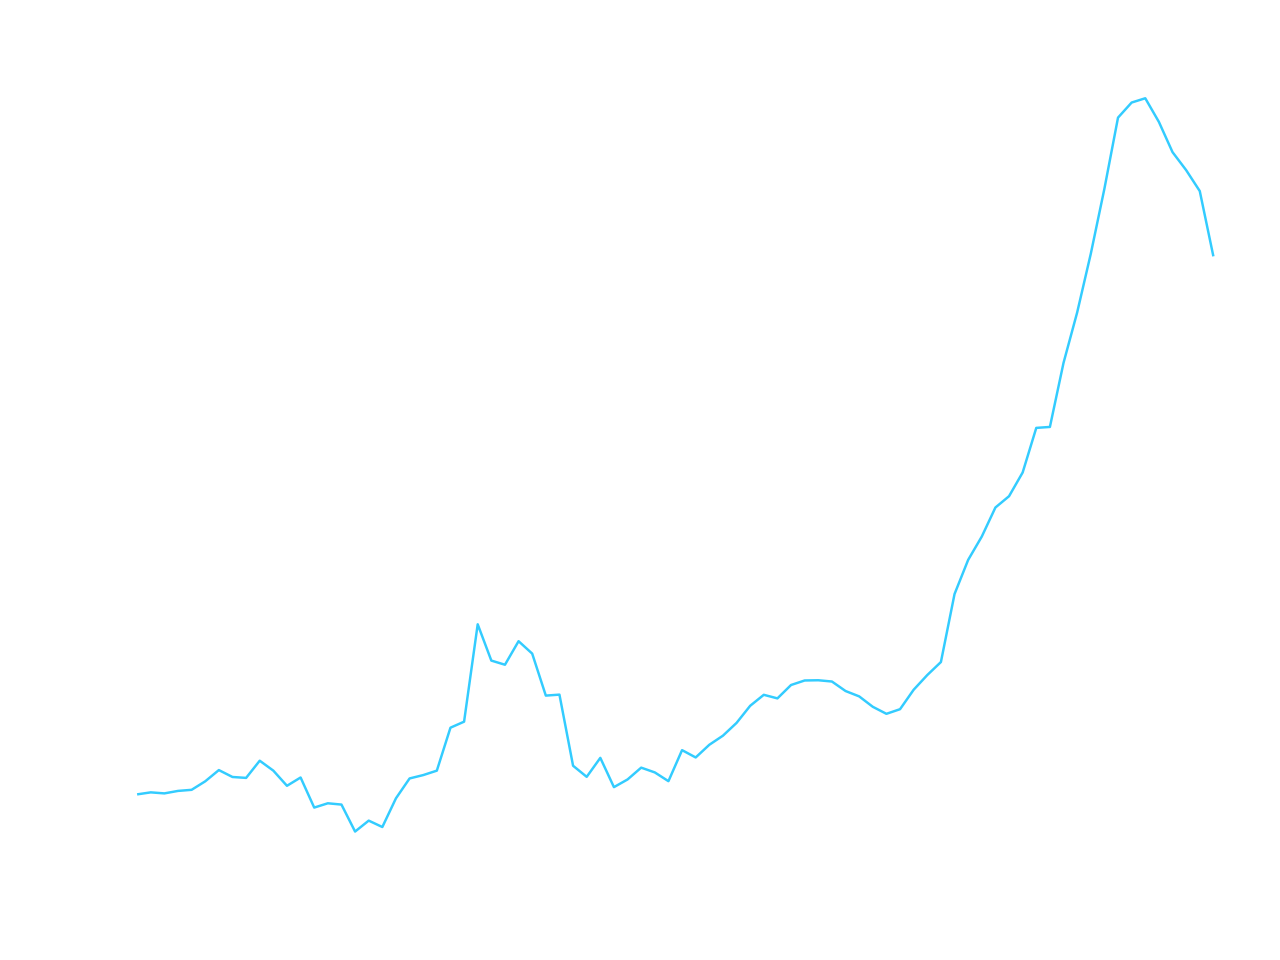

In [3]:
df = pd.read_sql('SELECT year, rain_relative_appearances FROM perception', engine)

g = (ggplot(df) +
    aes(x='year', y='rain_relative_appearances') +
    geom_line(color='#33ccff') +
    labs(title='Do people think London is rainy?', x='Year', y='Rainy perception (index 1940)') +
    theme(axis_text_x=element_text(angle=45, hjust=1),
        axis_title=element_text(weight='bold'),
        plot_title=element_text(weight='bold'),
          panel_grid=element_blank()) +
    theme_minimal() +
    theme(text=element_text(color="white"),line=element_line(color="white"))
)

g.save('../docs/images/london_rain_perception.svg')
g

## Precipitation hours in London vs its perception as a rainy city

In [4]:
query = '''SELECT 
                strftime('%Y', date) AS year,
                AVG(precipitation_hours) AS precipitation_hours
            FROM 
                weather
            WHERE
                city == 'London'
            GROUP BY 
                year;'''

query_2 = 'SELECT rain_relative_appearances FROM perception;'

df = pd.concat([pd.read_sql(query, engine), pd.read_sql(query_2, engine)], axis=1)
df['year'] = pd.to_numeric(df['year'])

/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 10 x 6 in image.
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: ../docs/images/london_precipitation_vs_perception.svg
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


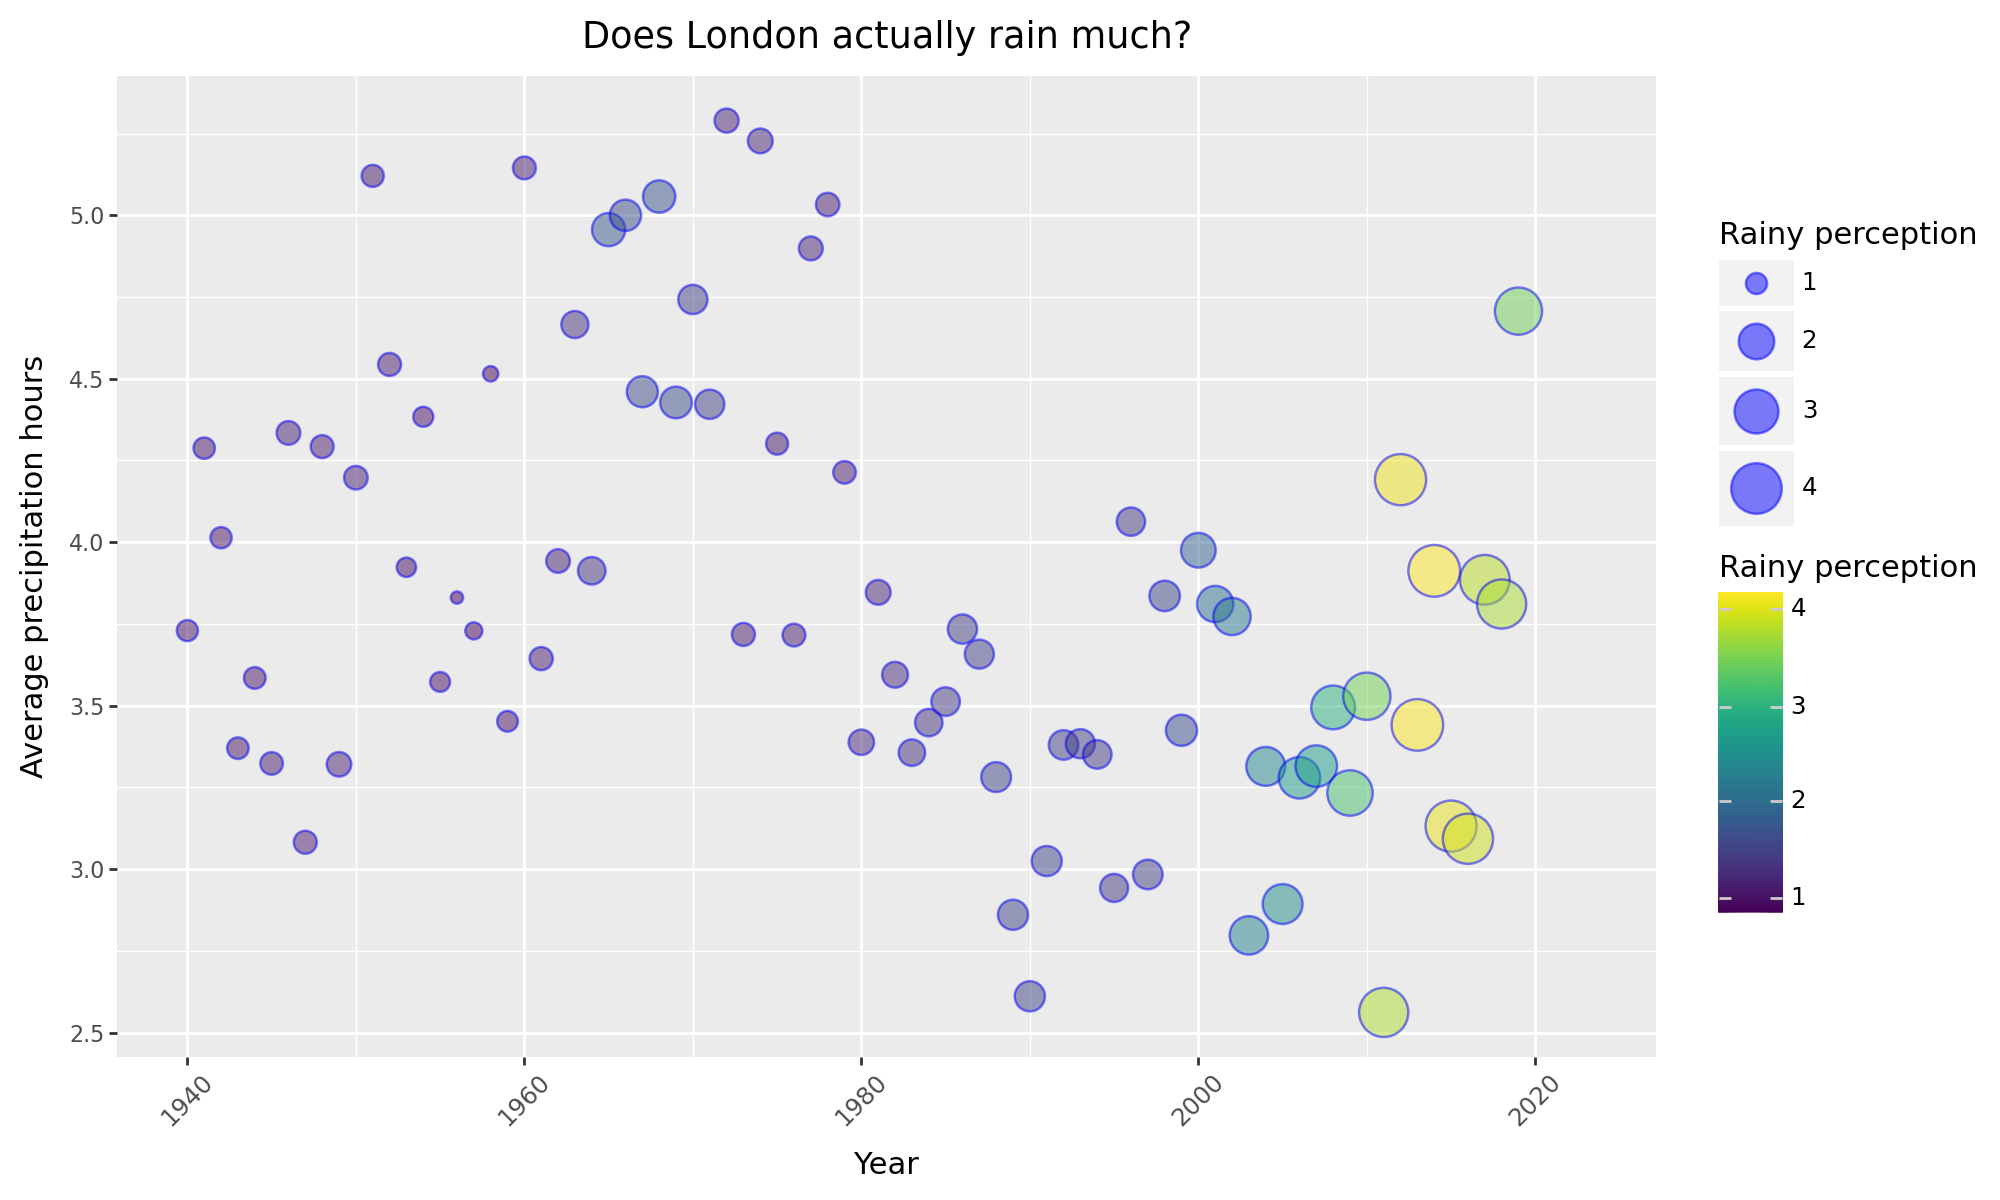

In [5]:
g = (ggplot(df, aes(x='year', y='precipitation_hours', size='rain_relative_appearances', fill = 'rain_relative_appearances')) + 
    geom_point(alpha=0.5, color='blue') + 
    scale_size_continuous(range=(2, 10), name='Rainy perception') + 
    scale_fill_continuous(name='Rainy perception') + 
    labs(title="Does London actually rain much?", x='Year', y='Average precipitation hours') + 
    theme(axis_text_y=element_text(size=8)) + 
    theme(figure_size=(10, 6)) + 
    theme(axis_text_x=element_text(rotation=45)) + 
    scale_x_continuous(breaks=range(1940,2021,20)))

g.save('../docs/images/london_precipitation_vs_perception.svg')
g

## London's sunniness vs its perception as a sunny place

In [6]:
query = '''SELECT 
                strftime('%Y', date) AS year,
                AVG(sunshine_duration) AS sunshine_duration
            FROM 
                weather
            WHERE
                city == 'London'
            GROUP BY 
                year;'''

query_2 = 'SELECT sun_relative_appearances FROM perception;'

df = pd.concat([pd.read_sql(query, engine), pd.read_sql(query_2, engine)], axis=1)
df['year'] = pd.to_numeric(df['year'])

/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 10 x 6 in image.
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: ../docs/images/london_sun_vs_perception.svg
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


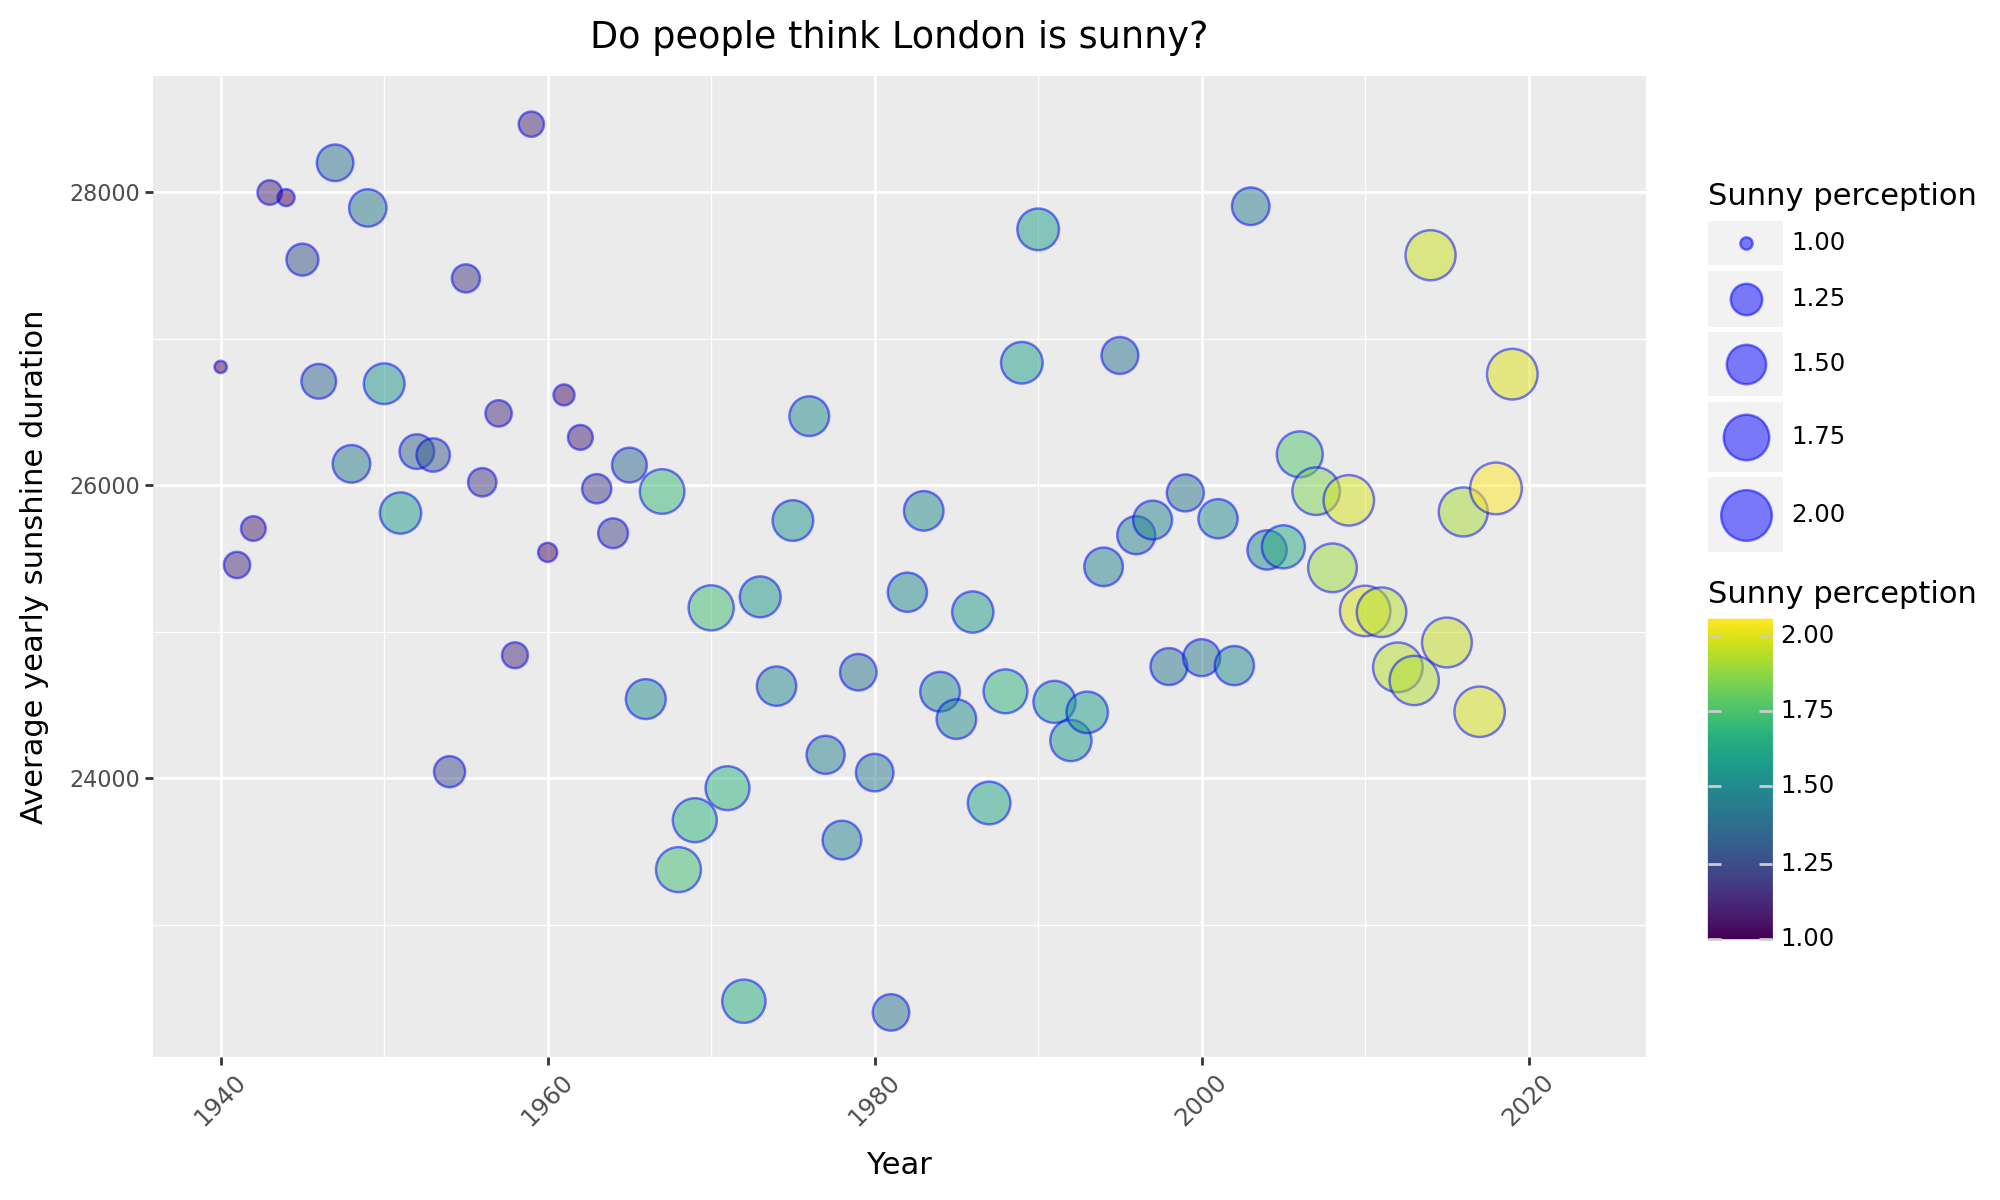

In [7]:
aesthetics = aes(x='year', y='sunshine_duration', size='sun_relative_appearances', fill = 'sun_relative_appearances')

# Create the plot
g = (ggplot(df, aesthetics) +
     geom_point(alpha=0.5, color='blue') +
     scale_size_continuous(range=(2, 10), name='Sunny perception') +
     scale_fill_continuous(name='Sunny perception') +
     labs(title="Do people think London is sunny?", x='Year', y='Average yearly sunshine duration') +
     theme(axis_text_y=element_text(size=8)) +
     theme(figure_size=(10, 6)) +
     theme(axis_text_x=element_text(rotation=45))
)

g.save('../docs/images/london_sun_vs_perception.svg')
g

In [8]:
query = '''SELECT 
                strftime('%Y', date) AS year,
                AVG(temperature_2m_mean) AS temperature_2m_mean
            FROM 
                weather
            WHERE
                city == 'London'
            GROUP BY 
                year;'''

query_2 = 'SELECT sun_relative_appearances FROM perception;'

df = pd.concat([pd.read_sql(query, engine), pd.read_sql(query_2, engine)], axis=1)
df['year'] = pd.to_numeric(df['year'])

/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 10 x 6 in image.
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: ../docs/images/london_temp_vs_perception.svg
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


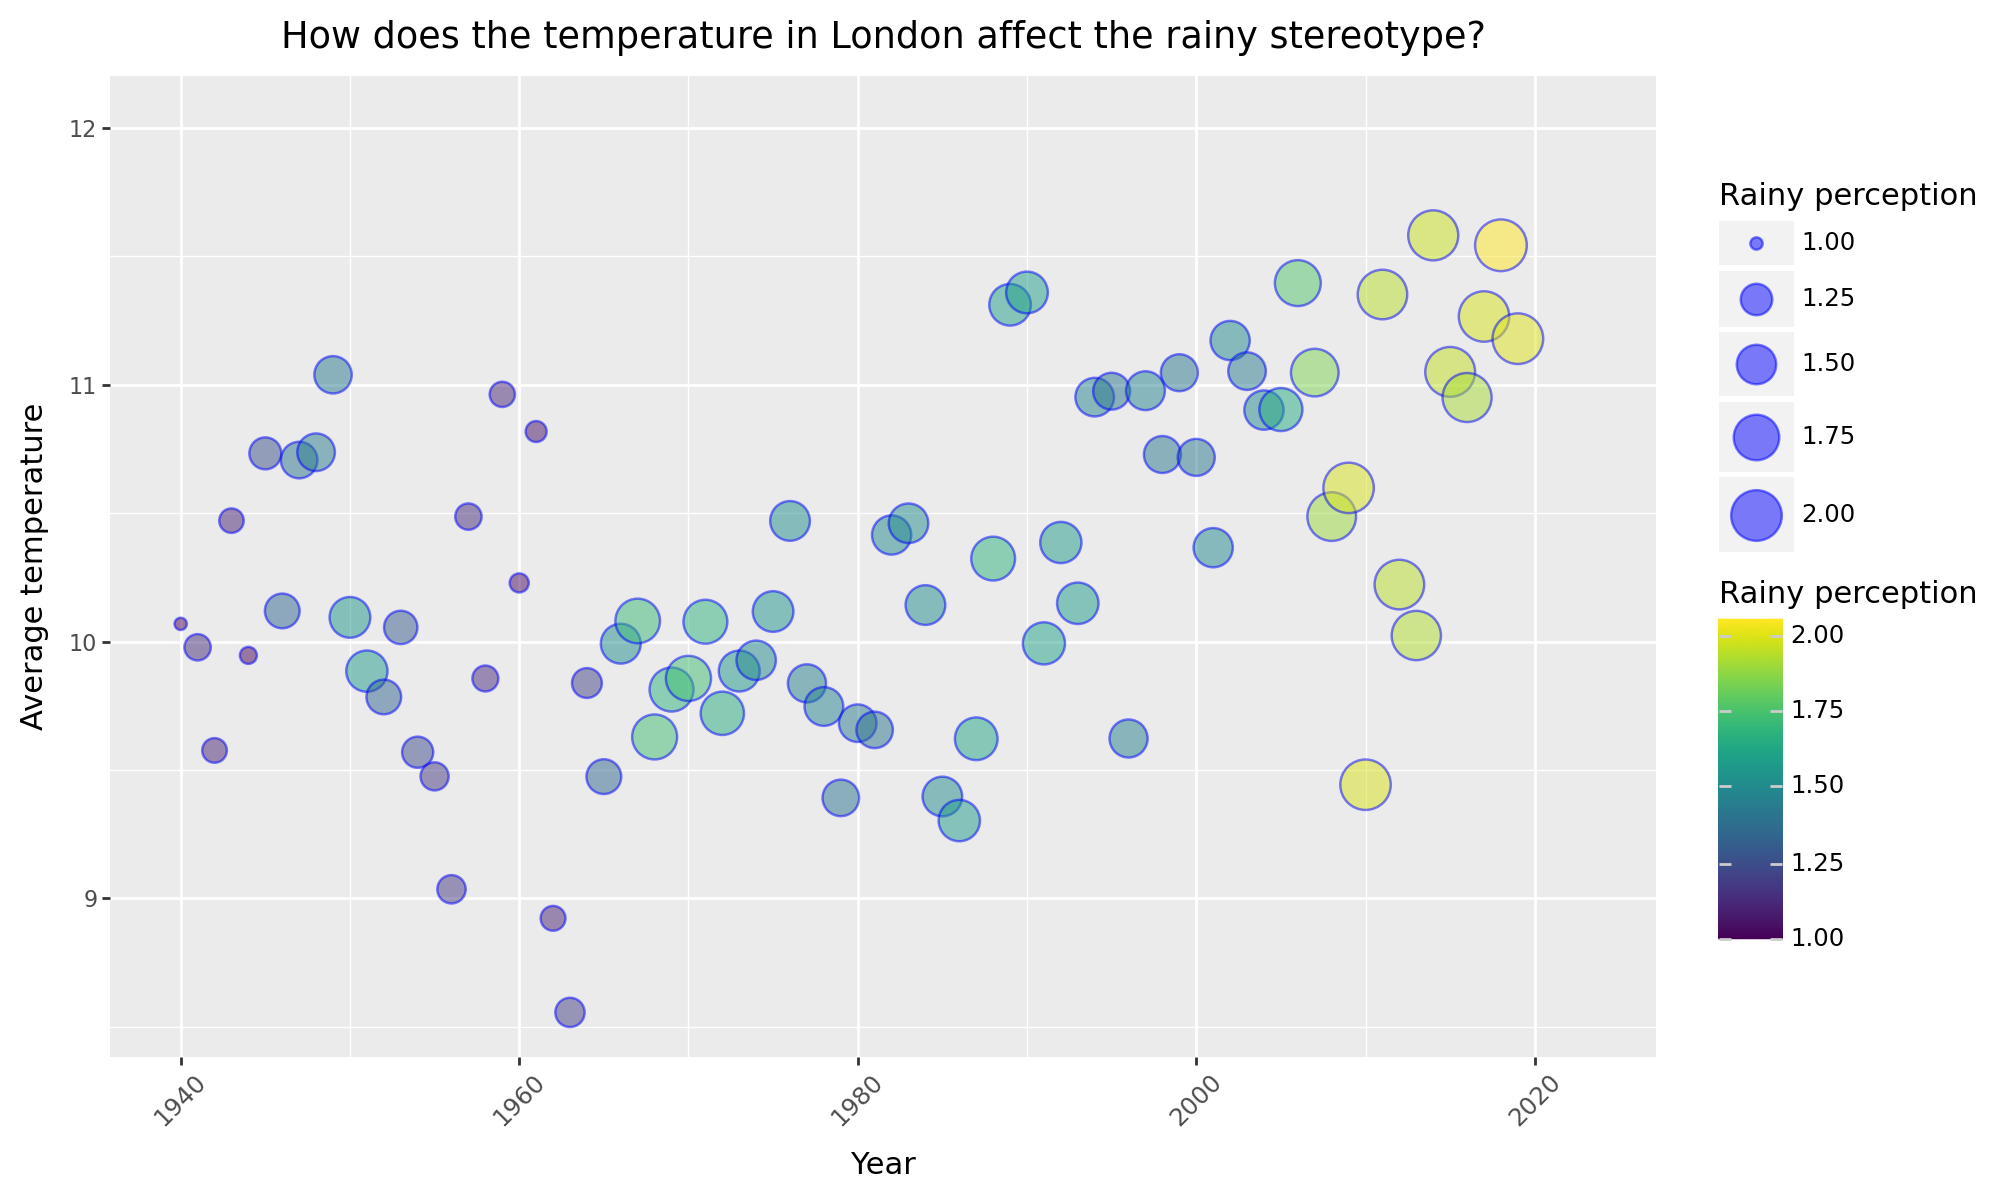

In [9]:
# Define aesthetics
aesthetics = aes(x='year', y='temperature_2m_mean', size='sun_relative_appearances', fill = 'sun_relative_appearances')

# Create the plot
g = (ggplot(df, aesthetics) +
     geom_point(alpha=0.5, color='blue') +
     scale_size_continuous(range=(2, 10), name='Rainy perception') +
     scale_fill_continuous(name='Rainy perception') +
     labs(title="How does the temperature in London affect the rainy stereotype?", x='Year', y='Average temperature') +
     theme(axis_text_y=element_text(size=8)) +
     theme(figure_size=(10, 6)) +
     theme(axis_text_x=element_text(rotation=45))
)

g.save('../docs/images/london_temp_vs_perception.svg')
g

## Yearly precipitation hours in London

In [10]:
query = '''
            SELECT 
                strftime("%Y", date) AS year,
                SUM(precipitation_hours) AS precipitation_hours
            FROM 
                weather
            WHERE
                city == "London"
            GROUP BY 
                year;
'''

df = pd.read_sql(query, engine)

/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: ../docs/images/london_precipitation_hours.svg


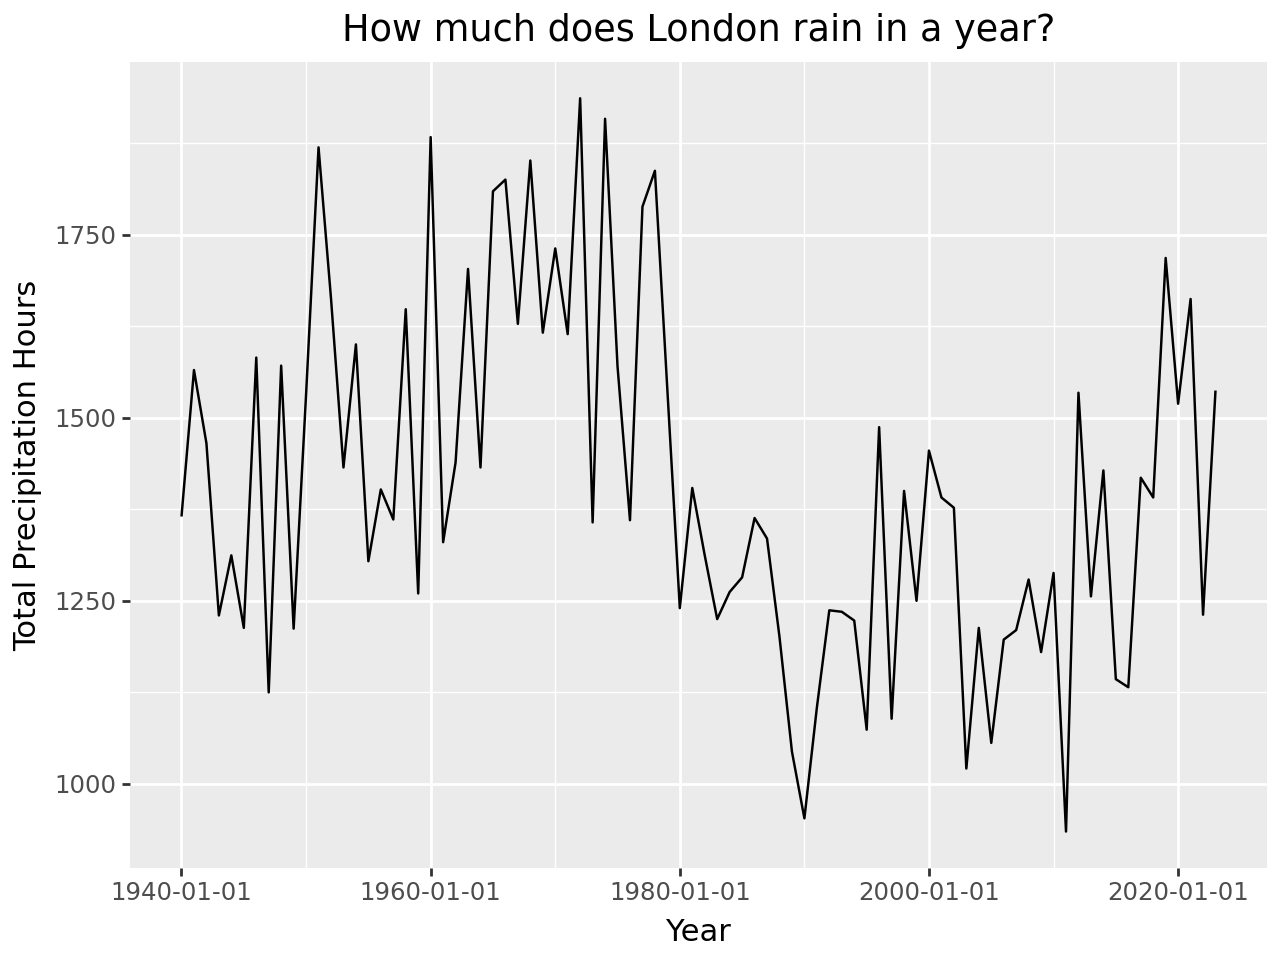

In [11]:
df['year'] = pd.to_datetime(df['year'])

g = (
    ggplot(df, aes(x='year', y='precipitation_hours')) + 
    geom_line() + 
    labs(title="How much does London rain in a year?", 
         x='Year', 
         y='Total Precipitation Hours')
)

g.save('../docs/images/london_precipitation_hours.svg')
g

# Average precipitation sum across all twenty cities

In [12]:
query = '''
    SELECT 
        city,
        AVG(precipitation_sum) AS avg_precipitation_sum
    FROM 
        weather
    GROUP BY 
        city;
'''

df = pd.read_sql(query, engine)
df['avg_precipitation_sum'] = pd.to_numeric(df['avg_precipitation_sum'])

df = df.sort_values(by='avg_precipitation_sum', ascending=True).reset_index(drop=True)
df['city'] = pd.Categorical(df['city'], categories=df['city'], ordered=True)

/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: ../docs/images/precipitation_sum_bar.svg


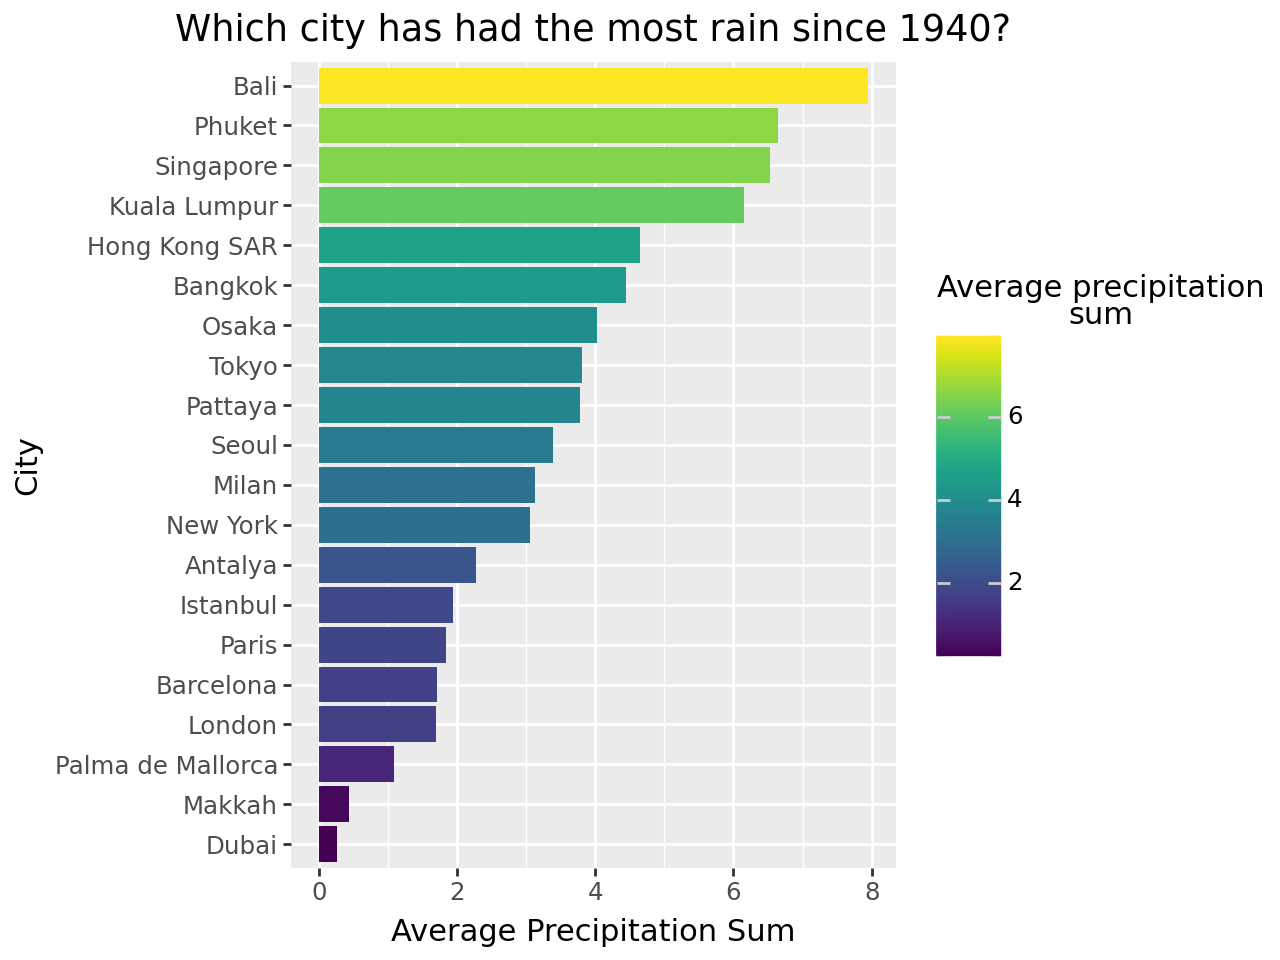

In [13]:
g = (ggplot(df, aes(x = 'city', y = 'avg_precipitation_sum', fill = 'avg_precipitation_sum')) + 
     coord_flip() + 
     geom_col() + 
     xlab('City') + 
     ylab('Average Precipitation Sum') +
     labs(title = 'Which city has had the most rain since 1940?', fill='Average precipitation\nsum') 
     )

g.save('../docs/images/precipitation_sum_bar.svg')
g

# Average precipitation hours across all twenty cities

In [14]:
query = '''
    SELECT 
        city,
        AVG(precipitation_hours) AS avg_precipitation_hours
    FROM 
        weather
    GROUP BY 
        city;
'''

df = pd.read_sql(query, engine)
df['avg_precipitation_hours'] = pd.to_numeric(df['avg_precipitation_hours'])

df = df.sort_values(by='avg_precipitation_hours', ascending=True).reset_index(drop=True)
df['city'] = pd.Categorical(df['city'], categories=df['city'], ordered=True)


/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: ../docs/images/precipitation_hours_bar.svg


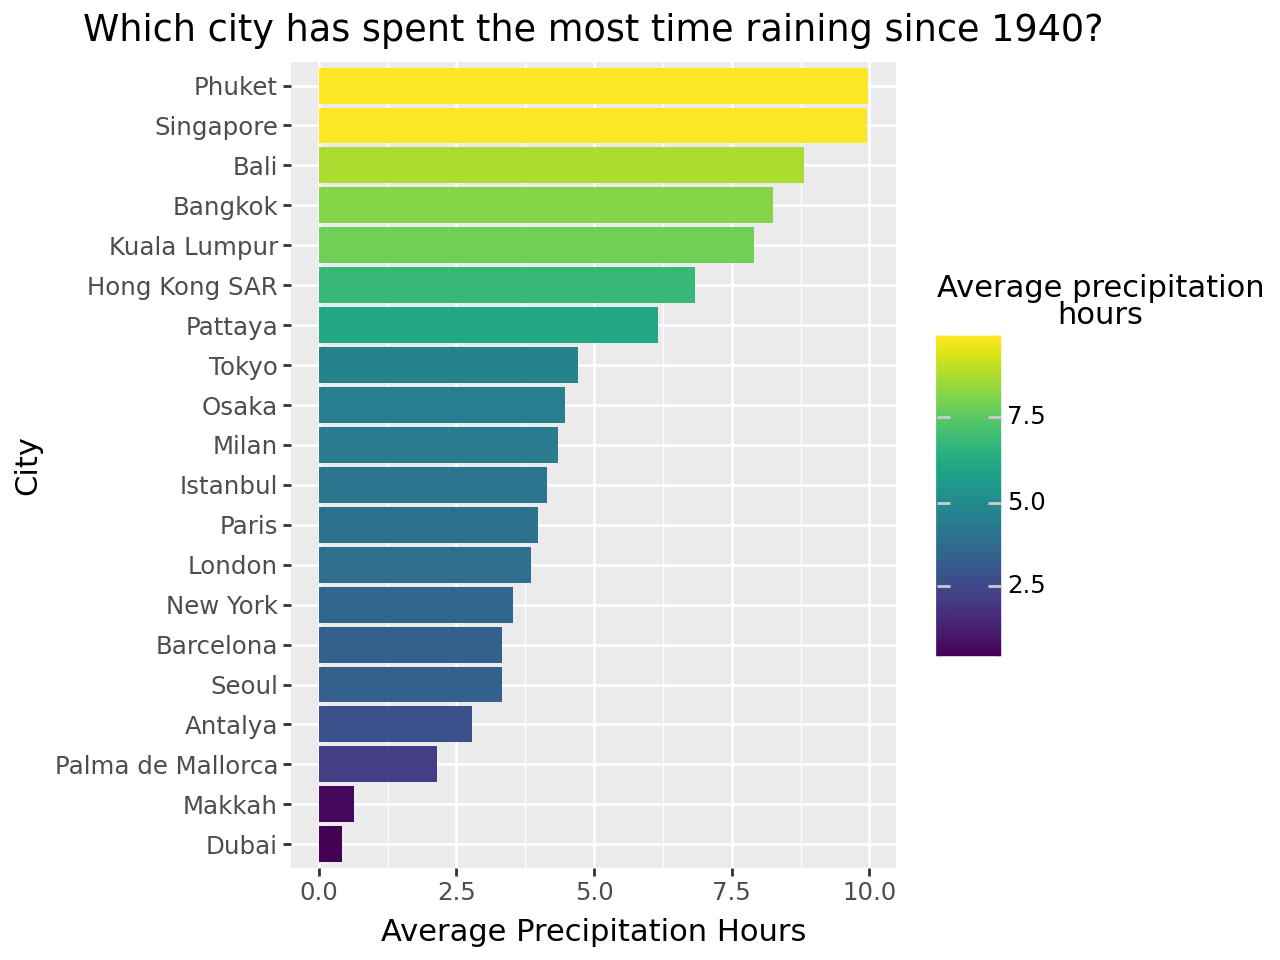

In [15]:
g = (ggplot(df, aes(x = 'city', y = 'avg_precipitation_hours', fill = 'avg_precipitation_hours')) + 
     coord_flip() + 
     geom_col() + 
     xlab('City') + 
     ylab('Average Precipitation Hours') +
     labs(title = 'Which city has spent the most time raining since 1940?', fill='Average precipitation\nhours') 
     )

g.save('../docs/images/precipitation_hours_bar.svg')
g

# Precipitation sum across European cities

In [16]:
european_cities = ['Barcelona', 'London', 'Milan', 'Palma de Mallorca', 'Paris']

city_list = ', '.join([f"'{city}'" for city in european_cities])

query = f'''
            SELECT 
                strftime("%Y", date) AS year,
                SUM(precipitation_sum) AS precipitation_sum,
                city
            FROM 
                weather
            WHERE
                city IN ({city_list})
            GROUP BY 
                year,
                city;
'''

df = pd.read_sql(query, engine)

df['year'] = pd.to_datetime(df['year'])
df = df.set_index(['year', 'city']).unstack('city').resample('5YE').mean()

df.columns = df.columns.get_level_values(1)
df = df.reset_index()

df = df.melt(id_vars=['year'], var_name='city', value_name='avg_precipitation_sum')

/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: ../docs/images/european_precipitation_sum.svg


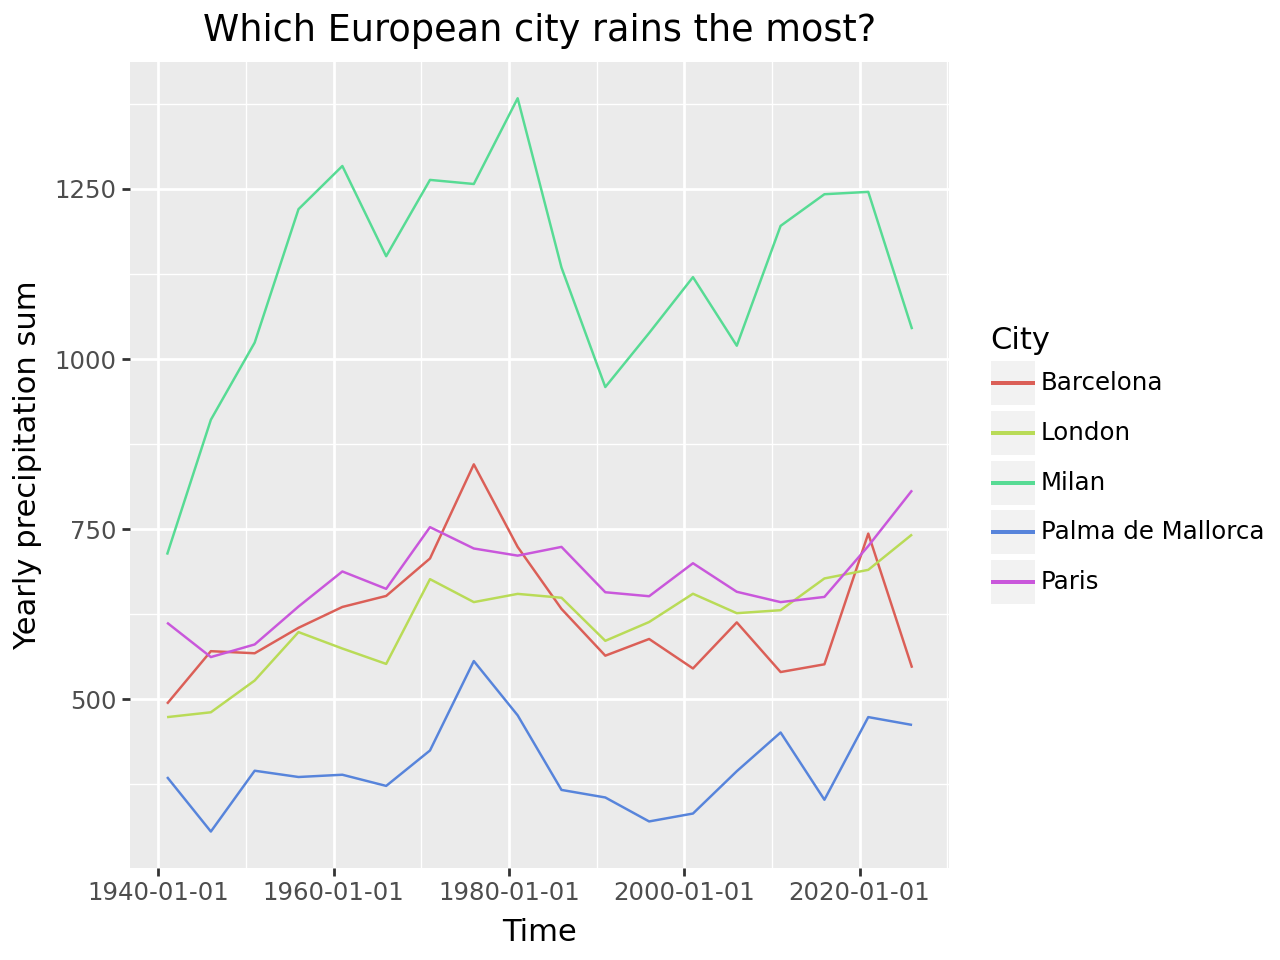

In [17]:
g = (ggplot(df) +
     aes(x='year', y='avg_precipitation_sum', color='city') + 
     geom_line() +
     labs(title='Which European city rains the most?',
          x='Time',
          y='Yearly precipitation sum',
          color='City')
)

g.save('../docs/images/european_precipitation_sum.svg')
g

# Precipitation hours across European cities

In [18]:
query = f'''
            SELECT 
                strftime("%Y", date) AS year,
                SUM(precipitation_hours) AS precipitation_hours,
                city
            FROM 
                weather
            WHERE
                city IN ({city_list})
            GROUP BY 
                year,
                city;
'''

df = pd.read_sql(query, engine)

df['year'] = pd.to_datetime(df['year'])
df = df.set_index(['year', 'city']).unstack('city').resample('5YE').mean()

df.columns = df.columns.get_level_values(1)
df = df.reset_index()

df = df.melt(id_vars=['year'], var_name='city', value_name='avg_precipitation_hours')

/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/olivergregory/opt/anaconda3/lib/python3.9/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: ../docs/images/european_precipitation_hours.svg


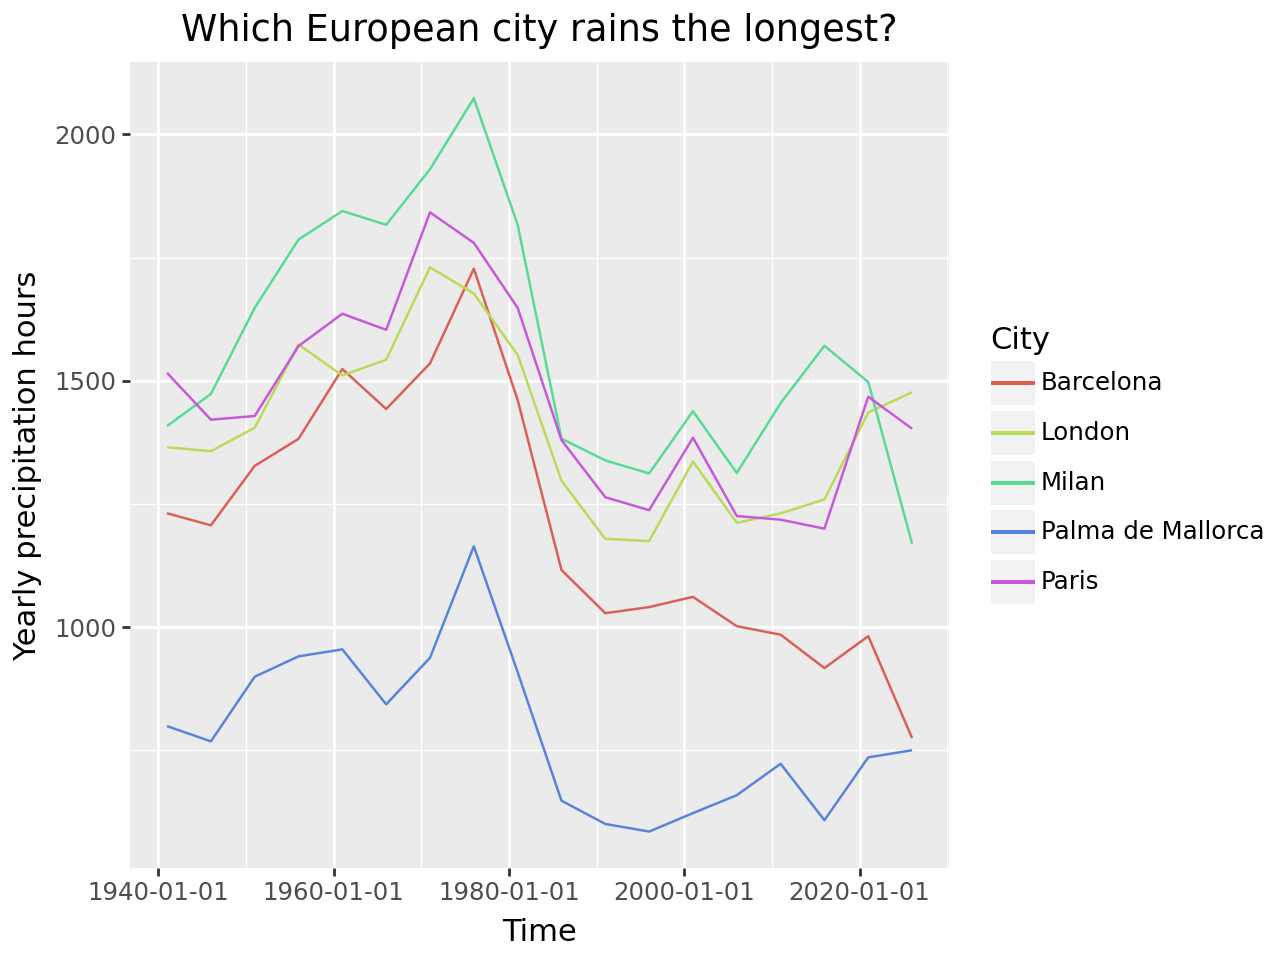

In [19]:
g = (ggplot(df) +
     aes(x='year', y='avg_precipitation_hours', color='city') + 
     geom_line() +
     labs(title='Which European city rains the longest?',
          x='Time',
          y='Yearly precipitation hours',
          color='City')
)

g.save('../docs/images/european_precipitation_hours.svg')
g

# Interactive graphs

In [20]:
query = f'''
            SELECT 
                strftime("%Y", date) AS year,
                SUM(precipitation_sum) AS precipitation_sum,
                city
            FROM 
                weather
            GROUP BY 
                year,
                city;
'''

df = pd.read_sql(query, engine)

df['year'] = pd.to_datetime(df['year'])

In [21]:
# Creating Plotly figure
fig_1 = px.line(df, x='year', y='precipitation_sum', color='city',
              title='Yearly Precipitation Sum Across 20 Cities',
              labels={'precipitation_sum': 'Total Precipitation (mm)', 'year': 'Year', 'city': 'City'})

# Adding a range slider for year selection
fig_1.update_layout(xaxis=dict(rangeslider=dict(visible=True)))

fig_1.show()

In [22]:
query = f'''
            SELECT 
                strftime("%Y", date) AS year,
                SUM(precipitation_hours) AS precipitation_hours,
                city
            FROM 
                weather
            GROUP BY 
                year,
                city;
'''

df = pd.read_sql(query, engine)

df['year'] = pd.to_datetime(df['year'])

In [23]:
# Creating Plotly figure
fig_2 = px.line(df, x='year', y='precipitation_hours', color='city',
              title='Yearly Precipitation Hours Across 20 Cities (1940-2024)',
              labels={'precipitation_hours': 'Total Precipitation Hours', 'year': 'Year', 'city': 'City'})

# Adding a range slider for year selection
fig_2.update_layout(xaxis=dict(rangeslider=dict(visible=True)))

fig_2.show()

# Word Clouds for auto suggestions of 20 Cities 

In [24]:
# Read the json file
with open('./../data/auto_suggestion_words.json','r') as file:
    weather_data = json.load(file)

In [25]:
# Create a directionary for words clouds
os.makedirs('./../docs/images/wordclouds', exist_ok=True)

In [26]:
# Generate word cloud for each city and display the image
for city, words in weather_data.items():
    description = ' '.join(words)   
     
    # Generate word cloud with custom color function
    wordcloud = WordCloud(width=800, height=400, background_color=None, color_func=cf.custom_color_func, mode="RGBA").generate(description)
        
    # Save word cloud image to the specified path
    image_path = f'../docs/images/wordclouds/{city}.png'
    wordcloud.to_file(image_path)
    
    # Display the word cloud image
    display(Image(filename=image_path))
    print(f"Word cloud for {city}")

TypeError: to_file() got an unexpected keyword argument 'dpi'